In [1]:
from comet_ml import API
import comet_ml
import io
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import collections


from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from colour import Color

In [2]:
sns.set(context='paper', style="whitegrid", font_scale=3, font = 'serif')

%matplotlib inline
linewidth = 3

In [3]:
colors = ['midnightblue','steelblue', 'skyblue', 'orange', 'firebrick', 'red']

## Get data from comet.ml

In [4]:
comet_api = API(api_key='abUSnAytqEzSzLOxNLP1ohibs')
comet_api.get()

['ketrint', 'schattengenie']

In [5]:
def get_parameter_by_key(exp, key):
    parameters = exp.get_parameters_summary()
    for parameter in parameters:
        if parameter['name'] == key:
            return parameter['valueCurrent']


In [6]:
def get_parameter_by_key(exp, key):
    parameters = exp.get_parameters_summary()
    for parameter in parameters:
        if parameter['name'] == key:
            return parameter['valueCurrent']
    return None

def new_to_old_metric(exp, key):
    metric = exp.get_metrics(key)
    vals = [float(m['metricValue']) for m in metric]
    return vals

def stack_lists(data, n=1000):
    new_data = []
    for d in data:
        if len(d) > n:
            new_data.append(d[:n])
        elif len(d) < n:
            new_data.append(
                np.concatenate([d, d[-1].repeat(n - len(d))])
            )
    return np.vstack(new_data).T

def preprocess_gp(vals):
    return np.minimum.accumulate(vals)

def add_zero_point(vals, point):
    return np.array([point] + vals.tolist())

In [7]:
def plot_mean(idx, mean, label="", i=0):
    idx = np.array(idx)
    mean = np.array(mean)
    plt.scatter(idx, mean, c=colors[i], linewidth=linewidth, label=label, zorder=5, s = 400)

## Parameteres tables 

In [8]:
experiments_name = ['param-choice-10kcv']

In [9]:
experiments = comet_api.get(workspace='ketrint', project_name=experiments_name)

In [10]:
len(experiments)

481

In [11]:
experiments_balanced_em = [
    exp for exp in experiments
    if get_parameter_by_key(exp, "num_layers_edge_conv") == '3' and
    get_parameter_by_key(exp, "num_layers_emulsion") == '5' and 
    get_parameter_by_key(exp, "datafile") == './data_new/data/rand_preprocessed.pt' 
]
experiments_balanced = [
    exp for exp in experiments
    if get_parameter_by_key(exp, "num_layers_edge_conv") == '4' and
    get_parameter_by_key(exp, "num_layers_emulsion") == '4' and 
    get_parameter_by_key(exp, "datafile") == './data_new/data/rand_preprocessed.pt' 
]
experiments_balanced_edge = [
     exp for exp in experiments
    if get_parameter_by_key(exp, "num_layers_edge_conv") == '5' and
    get_parameter_by_key(exp, "num_layers_emulsion") == '3' and 
    get_parameter_by_key(exp, "datafile") == './data_new/data/rand_preprocessed.pt' 
]

In [12]:
print(len(experiments_balanced_em), len(experiments_balanced), len(experiments_balanced_edge))

160 160 160


In [13]:
def append_value(dict_obj, key, value):
    if key in dict_obj:
        if not isinstance(dict_obj[key], list):
            dict_obj[key] = [dict_obj[key]]
        dict_obj[key].append(value)
    else:
        dict_obj[key] = value

In [14]:
from collections import defaultdict

def get_dicts(experiments):
    GS = defaultdict(list)
    E = defaultdict(list)
    for exp in experiments:
        good_showers = new_to_old_metric(exp, "Good showers")
        e = new_to_old_metric(exp, "Energy resolution")        
        if len(good_showers):
            threshold = float(exp.get_command()[-9])
            min_samples_core = int(exp.get_command()[-7])
            GS[min_samples_core].append((threshold,good_showers[0]))
            E[min_samples_core].append((threshold,e[0]))
    return GS, E

In [15]:
GS_b_em, ER_b_em = get_dicts(experiments_balanced_em)
GS_b, ER_b = get_dicts(experiments_balanced)
GS_b_edge, ER_b_edge = get_dicts(experiments_balanced_edge)

In [16]:
def group_results(data):
    for key in list(data.keys()):   
        d = defaultdict(list)
        for k, *v in data[key]:
            d[k].append(v[0])
        data[key] = d
    return data

In [17]:
GS_b_em_grouped, ER_b_em_grouped = group_results(GS_b_em), group_results(ER_b_em)
GS_b_grouped, ER_b_grouped = group_results(GS_b), group_results(ER_b)
GS_b_edge_grouped, ER_b_edge_grouped = group_results(GS_b_edge), group_results(ER_b_edge)

In [18]:
def group_results(data):
    for key in list(data.keys()):   
        for new_key in data[key].keys():
            data[key][new_key] = (len(data[key][new_key]), np.round(np.mean(data[key][new_key]),3), np.round(np.std(data[key][new_key]),3))

In [19]:
for data in [GS_b_em_grouped, ER_b_em_grouped, GS_b_grouped, ER_b_grouped, GS_b_edge_grouped, ER_b_edge_grouped]:
    group_results(data)

In [25]:
GS_b_edge_grouped

defaultdict(list,
            {2: defaultdict(list,
                         {0.2: (10, 0.862, 0.016),
                          0.4: (10, 0.868, 0.02),
                          0.8: (10, 0.867, 0.02),
                          0.6: (10, 0.868, 0.02)}),
             4: defaultdict(list,
                         {0.2: (10, 0.857, 0.016),
                          0.6: (10, 0.866, 0.019),
                          0.4: (10, 0.866, 0.019),
                          0.8: (10, 0.866, 0.019)}),
             3: defaultdict(list,
                         {0.2: (9, 0.862, 0.014),
                          0.8: (10, 0.867, 0.02),
                          0.4: (9, 0.864, 0.019),
                          0.6: (10, 0.867, 0.02)}),
             5: defaultdict(list,
                         {0.2: (10, 0.854, 0.017),
                          0.8: (10, 0.862, 0.017),
                          0.4: (10, 0.862, 0.017),
                          0.6: (10, 0.862, 0.017)})})

In [21]:
import pandas as pd
GS_table = pd.DataFrame([GS_b_em_grouped, GS_b_grouped, GS_b_edge_grouped], 
                        index=['Mix em', 'Mix equal', 'Mix edge'])
ER_table = pd.DataFrame([ER_b_em_grouped, ER_b_grouped, ER_b_edge_grouped], 
                        index=['Mix em', 'Mix equal', 'Mix edge'])

In [22]:
ER_table[5][2]

defaultdict(list,
            {0.2: (10, 0.183, 0.012),
             0.8: (10, 0.192, 0.008),
             0.4: (10, 0.192, 0.008),
             0.6: (10, 0.192, 0.008)})

In [23]:
GS_table[5][2]

defaultdict(list,
            {0.2: (10, 0.854, 0.017),
             0.8: (10, 0.862, 0.017),
             0.4: (10, 0.862, 0.017),
             0.6: (10, 0.862, 0.017)})

## Parameteres choosing final graph 

In [44]:
from collections import defaultdict

GS = defaultdict(list)
E = defaultdict(list)
for exp in experiments_balanced_edge:
    min_samples_core = int(exp.get_command()[-7])
    if min_samples_core == 2:
        good_showers = new_to_old_metric(exp, "Good showers")
        e = new_to_old_metric(exp, "Energy resolution")
        if len(good_showers):
            threshold = float(exp.get_command()[-9])
            GS[threshold].append(good_showers[0])
            E[threshold].append(e[0])

In [45]:
GS_od = collections.OrderedDict(sorted(GS.items()))
E_od = collections.OrderedDict(sorted(E.items()))

In [65]:
GS_od

OrderedDict([(0.2,
              [0.8586602166368703,
               0.8776371308016878,
               0.8377455166524338,
               0.8421649484536082,
               0.8888097660223805,
               0.8747168324633113,
               0.8521677327647477,
               0.8728863546991742,
               0.862964527027027,
               0.850979962772364]),
             (0.4,
              [0.884635608371017,
               0.8832278481012659,
               0.8377455166524338,
               0.8409278350515464,
               0.8886063072227874,
               0.8522692659153214,
               0.879444499162809,
               0.8659206081081081,
               0.850979962772364,
               0.8940228077074321]),
             (0.6,
              [0.884635608371017,
               0.8377455166524338,
               0.8839662447257384,
               0.8886063072227874,
               0.8394845360824742,
               0.8522692659153214,
               0.8781640894316951,


In [66]:
GS_mean = []
E_mean = []
for key in GS_od.keys():
    GS_mean.append(np.mean(GS_od[key]))
    E_mean.append(np.mean(E_od[key]))

In [67]:
GS_mean

[0.8618732988293607, 0.8677780259065084, 0.867579494698937, 0.8674043095589614]

In [68]:
E_mean

[0.175638976916974,
 0.1821585314785504,
 0.18316621135899583,
 0.18328994759073605]

In [69]:
keys = list(GS_od.keys())

In [70]:
keys

[0.2, 0.4, 0.6, 0.8]

In [49]:
#keys = [0.2, 0.4, 0.6, 0.8]

## Energy resolution - Recovered showers trade-off depending on the threshold

### Scatter plot

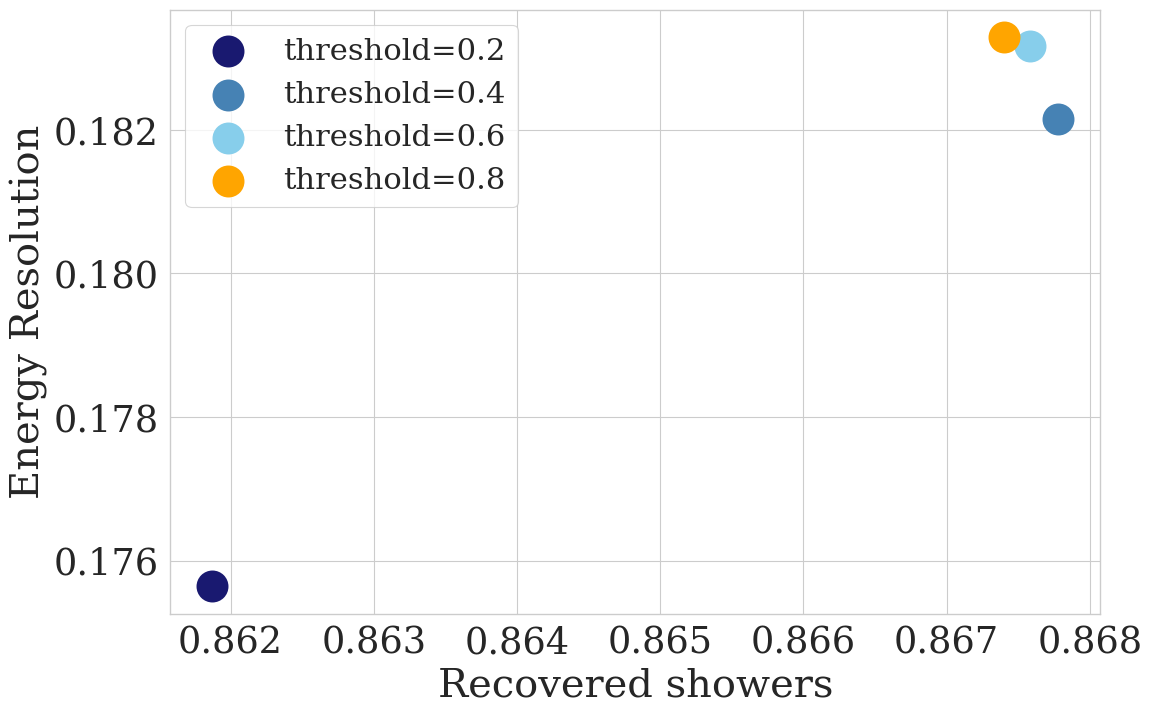

In [71]:
plt.figure(figsize=(12, 8), dpi=100)
plt.title("")
for i, key in enumerate(keys[:]):
    plot_mean(GS_mean[i], E_mean[i], label="threshold={}".format(key), i=i)
    

#plt.plot(GS_mean, E_mean)
plt.ylabel("Energy Resolution")
plt.xlabel("Recovered showers")
# plt.ylim
plt.legend(loc='best', fontsize=22)
plt.savefig("E_RS.pdf", bbox_inches='tight')
plt.show()

### Box plot

In [72]:
def boxplot_2d(x,y, color, ax, label, whis=1.5):
    xlimits = [np.percentile(x, q) for q in (25, 50, 75)]
    ylimits = [np.percentile(y, q) for q in (25, 50, 75)]
    
    x_std = np.std(x)
    y_std = np.std(y)

    ##the box
    box = Rectangle(
        (xlimits[1]-x_std/2,ylimits[1]-y_std/2),
        (x_std),
        (y_std),
        label=label,
        color=color,
        alpha = 0.5,
        ec = 'k',
        zorder=0
    )
    ax.add_patch(box)
    
    ##the x median
    vline = Line2D(
        [xlimits[1],xlimits[1]],[ylimits[1]-y_std/2,ylimits[1]+y_std/2],
        color='k',
        zorder=1
    )
    ax.add_line(vline)

    ##the y median
    hline = Line2D(
        [xlimits[1]-x_std/2,xlimits[1]+x_std/2],[ylimits[1],ylimits[1]],
        color='k',
        zorder=1
    )
    ax.add_line(hline)

    ##the central point
    ax.plot([xlimits[1]],[ylimits[1]], color='k', marker='o')

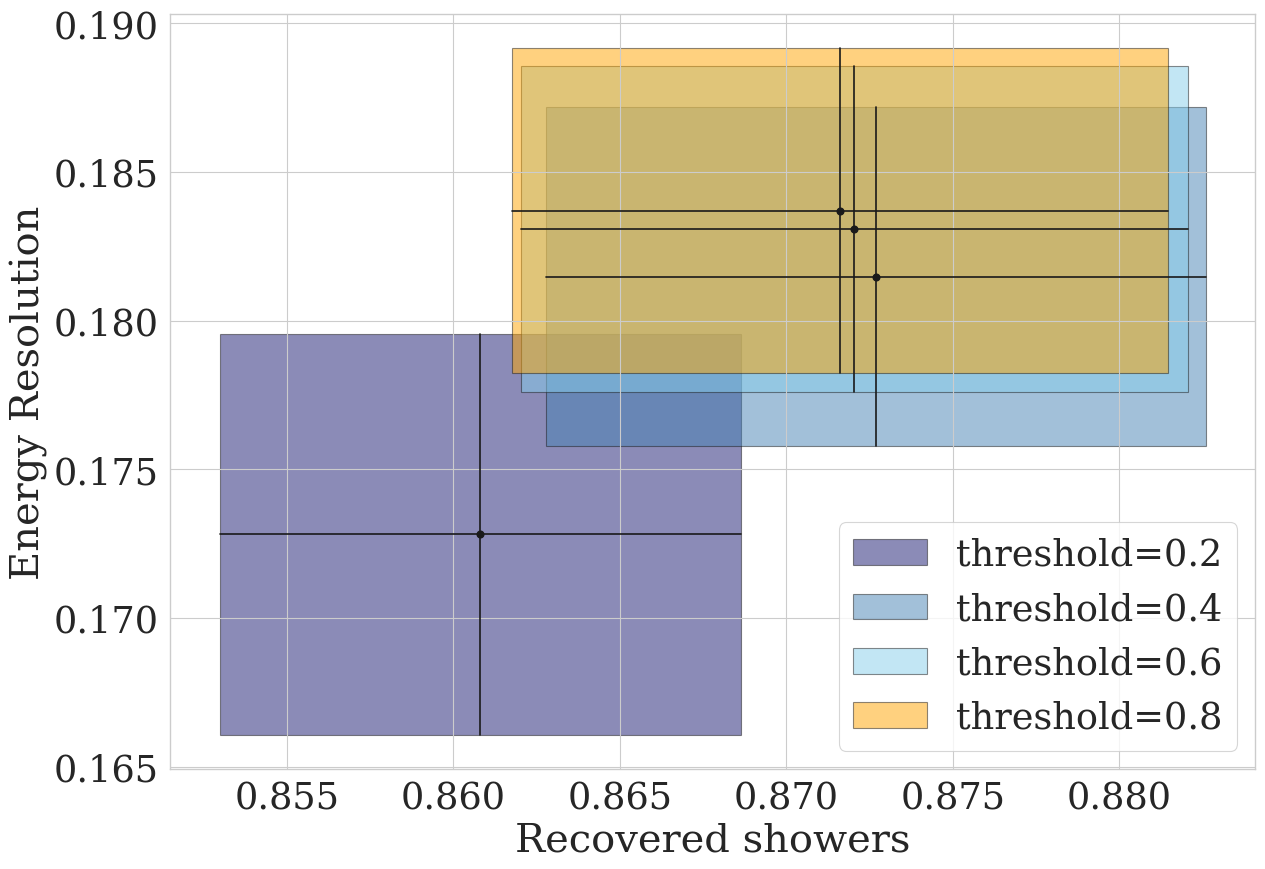

In [73]:
fig,(ax1) = plt.subplots(ncols=1, figsize=(14,10), dpi=100)
plt.title("")
for i, key in enumerate(keys[:]):
    x = np.array(GS_od[key])
    y = np.array(E_od[key])
    boxplot_2d(x,y, colors[i],  ax=ax1, whis=1, label="threshold={}".format(key))
    

#plt.plot(GS_mean, E_mean)
plt.ylabel("Energy Resolution")
plt.xlabel("Recovered showers")
# plt.ylim
plt.legend(loc='best')
plt.savefig("E_RS.pdf", bbox_inches='tight')
plt.show()

## Cross-validation training 

In [8]:
num_epochs = 4050

experiments = [comet_api.get(workspace='ketrint', project_name='em-network-training-cv10-4k')]
              # comet_api.get(workspace='ketrint', project_name='em-network-training-cleared-dataset-pt2'),
              # comet_api.get(workspace='ketrint', project_name='em-network-training-cleared-dataset-pt3')]

experiments = [item for sublist in experiments for item in sublist]

experiments_balanced_edge = [
    exp for exp in experiments
    if get_parameter_by_key(exp, "num_layers_edge_conv") == '5' and
    get_parameter_by_key(exp, "num_layers_emulsion") == '3' and 
    get_parameter_by_key(exp, "datafile") == './data_new/data/rand_preprocessed.pt' 
]
experiments_balanced_em = [
    exp for exp in experiments
    if get_parameter_by_key(exp, "num_layers_edge_conv") == '3' and
    get_parameter_by_key(exp, "num_layers_emulsion") == '5' and 
    get_parameter_by_key(exp, "datafile") == './data_new/data/rand_preprocessed.pt' 
]
experiments_balanced = [
    exp for exp in experiments
    if get_parameter_by_key(exp, "num_layers_edge_conv") == '4' and
    get_parameter_by_key(exp, "num_layers_emulsion") == '4' and 
    get_parameter_by_key(exp, "datafile") == './data_new/data/rand_preprocessed.pt' 
]
experiments_emulsion = [
    exp for exp in experiments
    if get_parameter_by_key(exp, "num_layers_edge_conv") == '0'
]
experiments_edge = [
    exp for exp in experiments
    if get_parameter_by_key(exp, "num_layers_edge_conv") == '8'
]

experiments_edge_56 = [
    exp for exp in experiments
    if get_parameter_by_key(exp, "num_layers_edge_conv") == '56'
]

In [9]:
exp = experiments_balanced[0]
roc_auc_test = np.array(new_to_old_metric(exp, 'roc_auc_test'))
print(len(roc_auc_test))

4000


In [10]:
balanced_roc_auc = []
for exp in experiments_balanced:
    roc_auc_test = np.array(new_to_old_metric(exp, 'roc_auc_test'))
    balanced_roc_auc.append(roc_auc_test)
balanced_roc_auc = stack_lists(balanced_roc_auc, num_epochs)

balanced_roc_auc_em = []
for exp in experiments_balanced_em:
    roc_auc_test = np.array(new_to_old_metric(exp, 'roc_auc_test'))
    balanced_roc_auc_em.append(roc_auc_test)
balanced_roc_auc_em = stack_lists(balanced_roc_auc_em, num_epochs)

balanced_roc_auc_edge = []
for exp in experiments_balanced_edge:
    roc_auc_test = np.array(new_to_old_metric(exp, 'roc_auc_test'))
    balanced_roc_auc_edge.append(roc_auc_test)
balanced_roc_auc_edge = stack_lists(balanced_roc_auc_edge, num_epochs)

edge_roc_auc = []
for exp in experiments_edge:
    roc_auc_test = np.array(new_to_old_metric(exp, 'roc_auc_test'))
    edge_roc_auc.append(roc_auc_test)
edge_roc_auc = stack_lists(edge_roc_auc, num_epochs)

edge_em_roc_auc = []
for exp in experiments_edge_56:
    roc_auc_test = np.array(new_to_old_metric(exp, 'roc_auc_test'))
    edge_em_roc_auc.append(roc_auc_test)
edge_56_roc_auc = stack_lists(edge_em_roc_auc, num_epochs)

emulsion_roc_auc = []
for exp in experiments_emulsion:
    roc_auc_test = np.array(new_to_old_metric(exp, 'roc_auc_test'))
    emulsion_roc_auc.append(roc_auc_test)
emulsion_roc_auc = stack_lists(emulsion_roc_auc, num_epochs)

In [12]:
def plot_roc_auc_test(data, label="", i=0):
    idx = np.arange(50,4100,50)
    mean = data.mean(1)
    mean_50 = np.mean(mean.reshape(-1, 50), axis=1)
    std = data.std(1) / np.sqrt(data.shape[1])
    std_50 = np.mean(std.reshape(-1, 50), axis=1)
    upper = mean_50 + std_50
    lower = mean_50 - std_50
    plt.ylim([0.90,0.96])
    plt.xlim([100,4000])
    plt.plot(idx, mean_50, c=colors[i], linewidth=linewidth, label=label, zorder=5)
    plt.plot(idx, upper, 'b--', c=colors[i], zorder=5)
    plt.plot(idx, lower, 'b--', c=colors[i], zorder=5)
    plt.fill_between(idx, lower, upper, alpha=0.2, color=colors[i], zorder=5)



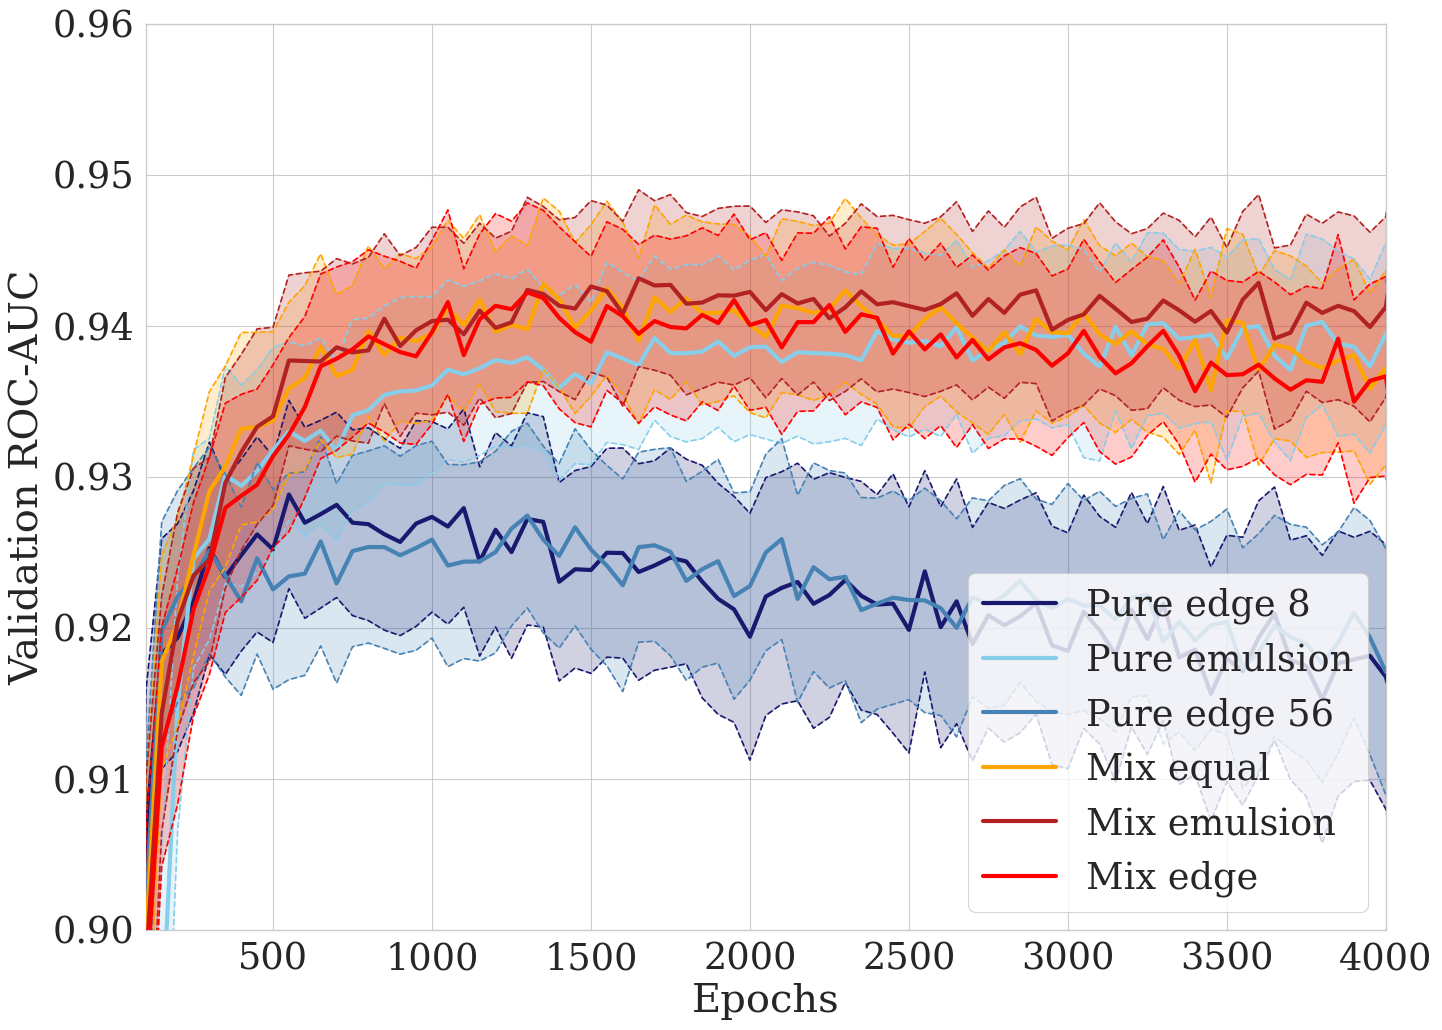

In [13]:
plt.figure(figsize=(16, 12), dpi=100)
plt.title("")
plot_roc_auc_test(edge_roc_auc, i=0, label="Pure edge 8")
plot_roc_auc_test(emulsion_roc_auc, i=2, label="Pure emulsion")
plot_roc_auc_test(edge_56_roc_auc, i=1, label="Pure edge 56")
plot_roc_auc_test(balanced_roc_auc, i=3, label="Mix equal")
plot_roc_auc_test(balanced_roc_auc_em, i=4, label="Mix emulsion")
plot_roc_auc_test(balanced_roc_auc_edge, i=5, label="Mix edge")

plt.ylabel("Validation ROC-AUC")
plt.xlabel("Epochs")
# plt.ylim
plt.legend(loc='lower right')
plt.savefig("validation_roc_auc.pdf", bbox_inches='tight')
plt.show()